<a href="https://colab.research.google.com/github/Bo-kyoung/practices/blob/main/VGG19_CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
  print("cuda")
  torch.cuda.manual_seed_all(777)


from torchvision import models
from torchsummary import summary


cuda


In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
   #,transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

In [ ]:
learning_rate = 0.001
training_epochs = 74
batch_size = 256

In [ ]:
CIFAR100_train = dsets.CIFAR100(root='data/',train = True, download=True, transform=transform)
CIFAR100_test = dsets.CIFAR100(root='d0ta/', train=False, download = True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
data_loader = DataLoader(dataset = CIFAR100_train, batch_size = batch_size, shuffle = True,drop_last = True)
test_loader = DataLoader(dataset = CIFAR100_test, batch_size = batch_size, shuffle = False,drop_last = True)


In [ ]:
len(CIFAR100_train.classes)

100

In [ ]:
class VGG19(nn.Module):
  def __init__(self, init_weights = True):
    super(VGG19, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =128,out_channels = 128,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =256,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =256,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =256,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels =256,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
        )
    
    #self.avgpool = nn.AdaptiveAvgPool2d(7)

    if init_weights: 
      self._initialize_weights()
    
    self.classfier = nn.Sequential(
    nn.Linear(2*2*512,4096),
    nn.ReLU(True),
    nn.Dropout(0.5), 
    nn.Linear(4096,4096),
    nn.ReLU(True),
    nn.Dropout(0.5), 
    nn.Linear(4096,100)
    )
  
  


  def forward(self, x):
    out = self.conv(x)
    #out = self.avgpool(out)
    out = out.view(out.size(0),-1)
    out = self.classfier(out)
    return out
#https://blog.naver.com/PostView.naver?blogId=mmmy2513&logNo=222300615187
#https://blogofth-lee.tistory.com/265?category=872318
  def _initialize_weights(self): 
    for m in self.modules(): 
      if isinstance(m, nn.Conv2d): 
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') 
        if m.bias is not None: 
          nn.init.constant_(m.bias, 0) 
      elif isinstance(m, nn.BatchNorm2d): 
        nn.init.constant_(m.weight, 1) 
        nn.init.constant_(m.bias, 0) 
      elif isinstance(m, nn.Linear): 
        nn.init.normal_(m.weight,0,0.01) 
        nn.init.constant_(m.bias, 0)



In [ ]:
model = VGG19().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(),lr = 0.01,momentum = 0.9)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma =0.9)

summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]         147,584
              ReLU-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 256, 16, 16]         295,168
             ReLU-11          [-1, 256, 16, 16]               0
           Conv2d-12          [-1, 256, 16, 16]         590,080
             ReLU-13          [-1, 256, 16, 16]               0
           Conv2d-14          [-1, 256,

In [ ]:
total_batch = len(data_loader)
print(total_batch)

195


4.603571891784668
acc: 1 %
[Epoch:    1] cost = 4.58970547
4.511988639831543
acc: 1 %
[Epoch:    2] cost = 4.47716141
4.473934173583984
acc: 1 %
[Epoch:    3] cost = 4.43789148
4.405548572540283
acc: 2 %
[Epoch:    4] cost = 4.39400005
4.344892978668213
acc: 2 %
[Epoch:    5] cost = 4.32577658
4.225255966186523
acc: 3 %
[Epoch:    6] cost = 4.15462208
4.008479595184326
acc: 4 %
[Epoch:    7] cost = 3.9128325
3.7354161739349365
acc: 5 %
[Epoch:    8] cost = 3.69598889
3.449211597442627
acc: 7 %
[Epoch:    9] cost = 3.49124026
3.2247016429901123
acc: 8 %
[Epoch:   10] cost = 3.28513622
3.139622688293457
acc: 9 %
[Epoch:   11] cost = 3.10310292
2.980908155441284
acc: 11 %
[Epoch:   12] cost = 2.91125989
2.7649152278900146
acc: 12 %
[Epoch:   13] cost = 2.7267971
2.6488590240478516
acc: 14 %
[Epoch:   14] cost = 2.5613265
2.528580665588379
acc: 15 %
[Epoch:   15] cost = 2.38234568
2.2831337451934814
acc: 17 %
[Epoch:   16] cost = 2.24770761
1.9789680242538452
acc: 18 %
[Epoch:   17] cost =

<function matplotlib.pyplot.show>

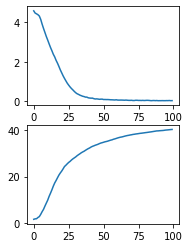

In [ ]:
correct = 0
total = 0
cor = 0
acc = []
loss_graph = []
training_epochs = 100

for epoch in range(training_epochs):
    avg_cost = 0


    for i , data in enumerate(data_loader, 0):
      X, Y = data
      X = X.to(device)
      Y = Y.to(device)
     
      hypothesis = model(X)
      cost = criterion(hypothesis, Y)
      optimizer.zero_grad()
      cost.backward()
      optimizer.step()
      if i %100 == 99 :
        print(cost.item())
      avg_cost += cost / total_batch
    
    loss_graph.append(avg_cost)
    with torch.no_grad():
      for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data,1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      cor = 100*correct/total
      acc.append(cor)
    print('acc: %d %%' % (100*correct/total))
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

loss_graph_2 = torch.as_tensor(loss_graph,device='cpu')
acc_2 = torch.as_tensor(acc,device='cpu')
plt.subplot(222)
plt.plot(loss_graph_2)
plt.subplot(224)
plt.plot(acc_2)
plt.show

In [ ]:
correct = 0
total = 0
cor = 0
acc = []

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data,1)

  total += labels.size(0)
  correct += (predicted == labels).sum().item()
  cor = 100*correct/total
  print('acc: %d %%' % (100*correct/total))

In [ ]:
import matplotlib.pyplot as plt
y_loss = {}
y_loss['train'] = []
y_loss['val']=[]
y_err={}
y_err['train'] = []
y_err['val'] = []

x_epoch=[]

       